In [1]:

import os
from PIL import Image, ImageDraw
import numpy as np
from torchvision import transforms
import mlflow
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import glob
import torch.optim as optim
import torch.onnx
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import dvc.api
import json
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from dvclive import Live
import torchvision.transforms.functional as F
import random
from PIL import Image, ImageEnhance
import numpy as np


# Prepare data

In [2]:
def create_center_mask(image_size, max_percentage=10):
    """
    Create a mask with a black square in the center for the region to inpaint.

    Args:
        image_size (tuple): (width, height) of the image.
        max_percentage (float): Maximum percentage of the image area covered by the square.

    Returns:
        Image: Binary mask where 1 (or 255) represents the inpainting region.
    """
    width, height = image_size
    max_area = (width * height) * (max_percentage / 100)  # Maximum area of the square
    side_length = int(max_area**0.5)

    # Create an empty mask
    mask = Image.new("L", (width, height), 0)  # Binary mask (0 for background)
    draw = ImageDraw.Draw(mask)

    # Define the square's position
    x0 = (width - side_length) // 2
    y0 = (height - side_length) // 2
    x1 = x0 + side_length
    y1 = y0 + side_length

    # Draw the inpainting region as white (255)
    draw.rectangle([x0, y0, x1, y1], fill=255)

    return mask


In [3]:
normalize_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()  
])
# Define augmentation for images
augmentation_transforms_image = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
])

# Define augmentation for masks (only flip and rotate)
augmentation_transforms_mask = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
])

# # augmentation_transforms = transforms.Compose([
# #     transforms.RandomHorizontalFlip(p=0.5),
# #     transforms.RandomRotation(degrees=15),
# #     transforms.ColorJitter(brightness=0.2, contrast=0.2),
# #     # transforms.ToTensor()
# # ])

# class PairedAugmentation:
#     def __init__(self, p=0.5):
#         self.p = p

#     def __call__(self, X_image, y_image, mask):
#         # Convert mask to PIL Image (required for transformations)
#         if not isinstance(mask, Image.Image):
#             mask = transforms.ToPILImage()(mask)

#         # Horizontal Flip (Applied to all)
#         if random.random() < self.p:
#             X_image = F.hflip(X_image)
#             y_image = F.hflip(y_image)
#             mask = F.hflip(mask)

#         # Vertical Flip (Applied to all)
#         if random.random() < self.p:
#             X_image = F.vflip(X_image)
#             y_image = F.vflip(y_image)
#             mask = F.vflip(mask)

#         # Random Rotation - Rotate by a random angle
#         if random.random() < self.p:
#             angle = random.randint(-15, 15)  # Angle range can be adjusted
#             X_image = F.rotate(X_image, angle)
#             y_image = F.rotate(y_image, angle)
#             mask = F.rotate(mask, angle)

#         # Random Affine Transformation (Scaling, Translation)
#         if random.random() < self.p:
#             max_translate = 10  # max pixels to translate
#             max_scale = 0.2  # max scaling
#             affine_params = (
#                 1 + random.uniform(-max_scale, max_scale),  # scale
#                 0,  # shear
#                 random.uniform(-max_translate, max_translate),  # translate x
#                 random.uniform(-max_translate, max_translate)  # translate y
#             )
#             # Correcting the resample method for affine transformation
#             X_image = F.affine(X_image, *affine_params, resample=Image.BICUBIC)
#             y_image = F.affine(y_image, *affine_params, resample=Image.BICUBIC)
#             mask = F.affine(mask, *affine_params, resample=Image.NEAREST)

#         # Random Resized Crop - zoom in/out effect
#         i, j, h, w = transforms.RandomResizedCrop.get_params(X_image, scale=(0.8, 1.0), ratio=(1.0, 1.0))
#         X_image = F.resized_crop(X_image, i, j, h, w, size=(X_image.height, X_image.width))
#         y_image = F.resized_crop(y_image, i, j, h, w, size=(y_image.height, y_image.width))
#         mask = F.resized_crop(mask, i, j, h, w, size=(mask.height, mask.width))

#         # Color Jitter (Only for input image, not mask)
#         X_image = transforms.ColorJitter(brightness=0.2, contrast=0.2)(X_image)

#         # Random Grayscale Conversion
#         if random.random() < self.p:
#             X_image = F.rgb_to_grayscale(X_image, num_output_channels=3)
#             y_image = F.rgb_to_grayscale(y_image, num_output_channels=3)

#         # Gaussian Blur (For noise augmentation)
#         if random.random() < self.p:
#             X_image = X_image.filter(ImageFilter.GaussianBlur(radius=2))  # Apply blur to input image
#             y_image = y_image.filter(ImageFilter.GaussianBlur(radius=2))  # Apply blur to target image

#         # Optional: Adjust mask brightness or contrast (you can skip this for masks if not needed)
#         mask = ImageEnhance.Contrast(mask).enhance(1.2)  # Slight contrast enhancement to mask

#         return X_image, y_image, mask


# # Instantiate augmentation with probability of 0.5
# augmentation_transforms = PairedAugmentation(p=0.5)


In [6]:
class InpaintingDataset(Dataset):
    def __init__(self, X_paths, y_paths, mask, transform=None, augment_image=None, augment_mask=None):
        """
        Args:
            X_paths (list): List of paths to holed images (input).
            y_paths (list): List of paths to ground truth images (target).
            mask (PIL.Image): Precomputed binary mask for the inpainting region.
            transform (callable, optional): Optional transform to apply to the images.
        """
        self.X_paths = X_paths  # Holed images (input)
        self.y_paths = y_paths  # Ground truth images (target)
        self.mask = mask  # Convert mask to a tensor
        self.transform = transform
        self.augment_image = augment_image
        self.augment_mask = augment_mask 

    def __len__(self):
        return len(self.X_paths)

    def __getitem__(self, idx):
        # Load the holed (input) and ground truth (target) images
        X_path = self.X_paths[idx]
        y_path = self.y_paths[idx]

        X_image = Image.open(X_path).convert("RGB")
        y_image = Image.open(y_path).convert("RGB")
        
        # Augment images
        if self.augment_image:
            X_image = self.augment_image(X_image)
            y_image = self.augment_image(y_image)

        # Augment masks (ensure the same augmentations but using augment_mask)
        mask = self.mask
        if self.augment_mask:
            mask = self.augment_mask(mask)

        # Apply transforms (normalization or other general transforms)
        if self.transform:
            X_image = self.transform(X_image)
            y_image = self.transform(y_image)

        # Ensure the mask has the same spatial dimensions as the image
        mask_tensor = transforms.ToTensor()(mask)
        if mask_tensor.shape[-2:] != X_image.shape[-2:]:
            mask_tensor = torch.nn.functional.interpolate(
                mask_tensor.unsqueeze(0), size=X_image.shape[-2:]
            ).squeeze(0)

        # Create 4-channel input (holed image + mask)
        combined_input = torch.cat((X_image, mask_tensor), dim=0)

        return combined_input, y_image  # (Input: X_image + mask, Target: y_image)


image_size = (224, 224)  
mask = create_center_mask(image_size, max_percentage=10)

#PATHS
holed_dir = "./safe-data/NormalizedData/HoledImages/"
ground_truth_dir = "./safe-data/NormalizedData/VegetableImages/"

#Get dirs to files
holed_paths = sorted(glob.glob(os.path.join(holed_dir, "*.*"), recursive=True))
ground_truth_paths = sorted(glob.glob(os.path.join(ground_truth_dir, "*.*"), recursive=True))
assert len(holed_paths) == len(ground_truth_paths), "Mismatch between holed and ground truth images"

# SPLIT DATASET
X_train, X_test, y_train, y_test = train_test_split(
    holed_paths, ground_truth_paths, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Create the datasets for train, validation, and test
mask = create_center_mask((224, 224), max_percentage=10)

train_dataset = InpaintingDataset(
    X_paths=X_train,
    y_paths=y_train,
    mask=mask,
    transform=normalize_transform,
    augment_image=augmentation_transforms_image,
    augment_mask=augmentation_transforms_mask
)

val_dataset = InpaintingDataset(
    X_paths=X_val,
    y_paths=y_val,
    mask=mask,
    transform=normalize_transform,
    augment_image=augmentation_transforms_image,
    augment_mask=augmentation_transforms_mask
)

test_dataset = InpaintingDataset(
    X_paths=X_test,
    y_paths=y_test,
    mask=mask,
    transform=normalize_transform,
    augment_image=augmentation_transforms_image,
    augment_mask=augmentation_transforms_mask
)

# Create DataLoaders for the datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the data
for combined_input, target in train_loader:
    print(f"Input shape: {combined_input.shape}, Target shape: {target.shape}")
    break


Input shape: torch.Size([64, 4, 128, 128]), Target shape: torch.Size([64, 3, 128, 128])


# DVC integration


In [8]:
# DVC integration
def log_params():
    params = {
        "Learning Rate": 1e-3,
        "Batch Size": 64,
        "Dataset Size": len(train_dataset),
        "Number of Epochs": 50,
        "Loss Function": "Masked MSE Loss"
    }
    with open('params.json', 'w') as f:
        json.dump(params, f)

def log_metrics(epoch, loss):
    # Use DVC metrics to log loss
    metrics = {
        "Train Loss": loss
    }
    with open(f"metrics_epoch_{epoch}.json", "w") as f:
        json.dump(metrics, f)

    # DVC command to push metrics
    os.system(f"dvc add metrics_epoch_{epoch}.json")

def log_artifacts(epoch, idx, input_image, target_image, inpainted_image):
    # Save and track the visualization
    visualization_path = f"./visualizations/epoch_{epoch}_example_{idx}.png"
    os.makedirs(os.path.dirname(visualization_path), exist_ok=True)
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(input_image)
    ax[0].set_title("Input (Holed)")
    ax[0].axis("off")

    ax[1].imshow(target_image)
    ax[1].set_title("Ground Truth")
    ax[1].axis("off")

    ax[2].imshow(inpainted_image)
    ax[2].set_title("Inpainted Output")
    ax[2].axis("off")

    plt.savefig(visualization_path)
    plt.close()

    # Track visualization with DVC
    os.system(f"dvc add {visualization_path}")

# DVC path tracking (update dataset path)
def track_dvc_data(holed_paths, ground_truth_paths):
    os.system(f"dvc add {' '.join(holed_paths)}")
    os.system(f"dvc add {' '.join(ground_truth_paths)}")

def create_center_mask(image_size, max_percentage=10):
    """
    Create a mask with a black square in the center for the region to inpaint.
    Args:
        image_size (tuple): (width, height) of the image.
        max_percentage (float): Maximum percentage of the image area covered by the square.
    Returns:
        Image: Binary mask where 1 (or 255) represents the inpainting region.
    """
    width, height = image_size
    max_area = (width * height) * (max_percentage / 100)  # Maximum area of the square
    side_length = int(max_area**0.5)

    # Create an empty mask
    mask = Image.new("L", (width, height), 0)  # Binary mask (0 for background)
    draw = ImageDraw.Draw(mask)

    # Define the square's position
    x0 = (width - side_length) // 2
    y0 = (height - side_length) // 2
    x1 = x0 + side_length
    y1 = y0 + side_length

    # Draw the inpainting region as white (255)
    draw.rectangle([x0, y0, x1, y1], fill=255)

    return mask

# Model

In [9]:
class FastInpaintingModelWithSkip(nn.Module):
    def __init__(self):
        super(FastInpaintingModelWithSkip, self).__init__()
        
        # Encoder layers
        self.enc1 = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=4, stride=2, padding=1),  # Fewer filters for faster computation
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Fewer parameters in bottleneck
            nn.ReLU()
        )
        
        # Decoder layers with skip connections
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # Skip connection from enc3
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64 + 64, 32, kernel_size=4, stride=2, padding=1),  # Skip connection from enc2
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.dec4 = nn.Sequential(
            nn.ConvTranspose2d(32 + 32, 3, kernel_size=4, stride=2, padding=1),  # Skip connection from enc1
            nn.Sigmoid()  # Pixel values in [0, 1]
        )
    
    def forward(self, x):
        # Encoding path
        enc1 = self.enc1(x)  # Output: (B, 32, 112, 112)
        enc2 = self.enc2(enc1)  # Output: (B, 64, 56, 56)
        enc3 = self.enc3(enc2)  # Output: (B, 128, 28, 28)
        
        # Bottleneck
        bottleneck = self.bottleneck(enc3)  # Output: (B, 256, 14, 14)
        
        # Decoding path with skip connections
        dec1 = self.dec1(bottleneck)  # Output: (B, 128, 28, 28)
        dec2 = self.dec2(torch.cat([dec1, enc3], dim=1))  # Skip connection from enc3
        dec3 = self.dec3(torch.cat([dec2, enc2], dim=1))  # Skip connection from enc2
        dec4 = self.dec4(torch.cat([dec3, enc1], dim=1))  # Skip connection from enc1
        
        return dec4

# Instantiate the model
model = FastInpaintingModelWithSkip()
print(model)


FastInpaintingModelWithSkip(
  (enc1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (bottleneck): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (dec1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (dec2): Sequential(
    (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding

In [10]:
loss_fn = nn.MSELoss()  # Pixel-wise MSE loss

In [11]:
def masked_loss(output, target, mask):
    """
    Compute MSE loss only for the masked region.

    Args:
        output (Tensor): Model output (B, C, H, W).
        target (Tensor): Ground truth image (B, C, H, W).
        mask (Tensor): Binary mask indicating the region to inpaint (B, 1, H, W).

    Returns:
        Tensor: Loss value.
    """
    mask = mask.to(output.device)  # Ensure mask is on the same device
    loss = ((output - target) ** 2) * mask  # Apply the mask
    return loss.sum() / mask.sum()  # Normalize by the number of pixels in the mask


In [12]:
# Initialize model, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FastInpaintingModelWithSkip().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()  # Pixel-wise MSE loss


In [13]:
# def log_visualizations(test_loader, model, step):
#     """
#     Generate and save visualizations of the inpainting results to MLflow.

#     Args:
#         test_loader (DataLoader): Test DataLoader.
#         model (torch.nn.Module): Trained inpainting model.
#         step (int): Current step or epoch.
#     """
#     model.eval()
#     with torch.no_grad():
#         for idx, (combined_input, target) in enumerate(test_loader):
#             combined_input, target = combined_input.to(device), target.to(device)
#             output = model(combined_input)

#             # Extract mask, input image, and ground truth
#             input_image = combined_input[:, :3, :, :].cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
#             mask = combined_input[:, 3:4, :, :].cpu().numpy()  # (B, 1, H, W)
#             target_image = target.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
#             output_image = output.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)

#             # Rescale images for visualization
#             input_image = (input_image * 255).astype(np.uint8)
#             target_image = (target_image * 255).astype(np.uint8)
#             output_image = (output_image * 255).astype(np.uint8)

#             # Combine inpainted region with the input image
#             inpainted_image = input_image[0].copy()
#             mask_numpy = mask[0, 0]  # Convert mask to 2D numpy array
#             inpainted_image[mask_numpy > 0] = output_image[0][mask_numpy > 0]

#             # Save the visualization
#             import matplotlib.pyplot as plt
#             fig, ax = plt.subplots(1, 3, figsize=(12, 4))
#             ax[0].imshow(input_image[0])
#             ax[0].set_title("Input (Holed)")
#             ax[0].axis("off")

#             ax[1].imshow(target_image[0])
#             ax[1].set_title("Ground Truth")
#             ax[1].axis("off")

#             ax[2].imshow(inpainted_image)
#             ax[2].set_title("Inpainted Output")
#             ax[2].axis("off")

#             # Save to a file
#             visualization_path = f"./visualizations/epoch_{step}_example_{idx}.png"
#             os.makedirs(os.path.dirname(visualization_path), exist_ok=True)
#             plt.savefig(visualization_path)
#             plt.close()

#             # Log to MLflow
#             mlflow.log_artifact(visualization_path, artifact_path="visualizations")

#             # Log only the first example
#             break


# Training

In [14]:
num_epochs = 8

start_time = time.time()

# Enable DVC experiment tracking
with Live(save_dvc_exp=True) as live:
    live.log_param("Learning Rate", 1e-3)
    live.log_param("Batch Size", 64)
    live.log_param("Dataset Size", len(train_dataset))
    live.log_param("Loss Function", "Masked MSE Loss")

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for combined_input, target in train_loader:
            combined_input, target = combined_input.to(device), target.to(device)

            mask = combined_input[:, 3:4, :, :]

            # Forward pass
            output = model(combined_input)
            loss = masked_loss(output, target, mask)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        live.log_metric("train/loss", avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}")

        # # Assuming 'idx' is just the current epoch number
        # idx = epoch  # Modify this if needed
        # # Log artifacts (assuming these variables exist)
        # log_artifacts(epoch, idx, input_image, target_image, inpainted_image)

        live.next_step()  # Mark the next training step
    total_time = time.time() - start_time  # Compute training duration
    live.log_metric("train/time", total_time)  # Log training time

    # Save the model and track with DVC
    torch.save(model.state_dict(), "model.pth")
    os.system("dvc add model.pth")


Epoch [1/8], Train Loss: 0.1643
Epoch [2/8], Train Loss: 0.1376
Epoch [3/8], Train Loss: 0.1359
Epoch [4/8], Train Loss: 0.1361
Epoch [5/8], Train Loss: 0.1358
Epoch [6/8], Train Loss: 0.1342
Epoch [7/8], Train Loss: 0.1323
Epoch [8/8], Train Loss: 0.1310


MergeConflictError: Stash apply resulted in merge conflicts

In [ ]:
# num_epochs = 8

# start_time = time.time()

# for epoch in range(num_epochs):
#     # Training Phase
#     model.train()
#     total_loss = 0.0

#     for combined_input, target in train_loader:
#         combined_input, target = combined_input.to(device), target.to(device)

#         mask = combined_input[:, 3:4, :, :]

#         # Forward pass
#         output = model(combined_input)
#         loss = masked_loss(output, target, mask)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     avg_loss = total_loss / len(train_loader)
#     log_metrics(epoch, avg_loss)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}")

#     # log_artifacts(epoch, epoch, combined_input, target, inpainted_image)

# # Save model after training
# torch.save(model.state_dict(), "model.pth")
# os.system("dvc add model.pth")

Epoch [1/8], Train Loss: 0.1598
Epoch [2/8], Train Loss: 0.1362
Epoch [3/8], Train Loss: 0.1316
Epoch [4/8], Train Loss: 0.1309
Epoch [5/8], Train Loss: 0.1265
Epoch [6/8], Train Loss: 0.1255
Epoch [7/8], Train Loss: 0.1286
Epoch [8/8], Train Loss: 0.1279


0

In [ ]:
# # Training Parameters
# num_epochs = 50


# # Training with MLflow Logging
# with mlflow.start_run(run_name="Inpainting Autoencoder Skip with better speed 50 epochs") as run:
#     run_id = run.info.run_id
#     with open("mlflow_run_id.txt", "w") as f:
#         f.write(run_id)
#     print(f"Run started with ID: {run_id}")
    
    
#     # Log parameters
#     mlflow.log_param("Learning Rate", 1e-3)
#     mlflow.log_param("Batch Size", 64)
#     mlflow.log_param("Dataset Size", len(train_dataset))
#     mlflow.log_param("Number of Epochs", num_epochs)
#     mlflow.log_param("Loss Function", "Masked MSE Loss")
#     start_time = time.time()
#     for epoch in range(num_epochs):
#         # Training Phase
#         model.train()
#         total_loss = 0.0

#         for combined_input, target in train_loader:
#             combined_input, target = combined_input.to(device), target.to(device)

#             mask = combined_input[:, 3:4, :, :]
            
#             # Forward pass
#             output = model(combined_input)
#             loss = masked_loss(output, target, mask)

#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()

#         avg_loss = total_loss / len(train_loader)
#         mlflow.log_metric("Train Loss", avg_loss, step=epoch)
#         print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}")


            
#         log_visualizations(test_loader, model, step=epoch)

#     total_training_time = time.time() - start_time
#     mlflow.log_metric("Training_Time_seconds", total_training_time)




In [13]:
# with open("mlflow_run_id.txt", "r") as f:
#     run_id = f.read().strip()
    
# with mlflow.start_run(run_id=run_id):


#     model_save_path = "./models/inpainting_model_weights_autoencoder_skip_fast.pth"
#     torch.save(model.state_dict(), model_save_path)
#     mlflow.log_artifact(model_save_path, artifact_path="models")

#     full_model_save_path = "./models/inpainting_model_full_autoencoder_skip_fast.pth"
#     torch.save(model, full_model_save_path)
#     mlflow.log_artifact(full_model_save_path, artifact_path="models")

In [14]:
def visualize_inpainting(test_loader, model):
    model.eval()
    with torch.no_grad():
        for combined_input, target in test_loader:
            combined_input, target = combined_input.to(device), target.to(device)
            output = model(combined_input)

            # Extract mask, input image, and ground truth
            input_image = combined_input[:, :3, :, :].cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
            mask = combined_input[:, 3:4, :, :].cpu().numpy()  # (B, 1, H, W)
            target_image = target.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
            output_image = output.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)

            # Rescale images from [0, 1] to [0, 255] for visualization
            input_image = (input_image * 255).astype(np.uint8)
            target_image = (target_image * 255).astype(np.uint8)
            output_image = (output_image * 255).astype(np.uint8)

            # Combine inpainted region with the input image for visualization
            inpainted_image = input_image[0].copy()
            mask_numpy = mask[0, 0]  # Convert mask to 2D numpy array
            inpainted_image[mask_numpy > 0] = output_image[0][mask_numpy > 0]

            # Visualize
            import matplotlib.pyplot as plt
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.title("Input (Holed)")
            plt.imshow(input_image[0])  # RGB image
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(target_image[0])  # RGB image
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Inpainted Output")
            plt.imshow(inpainted_image)  # RGB image
            plt.axis("off")

            plt.show()
            break


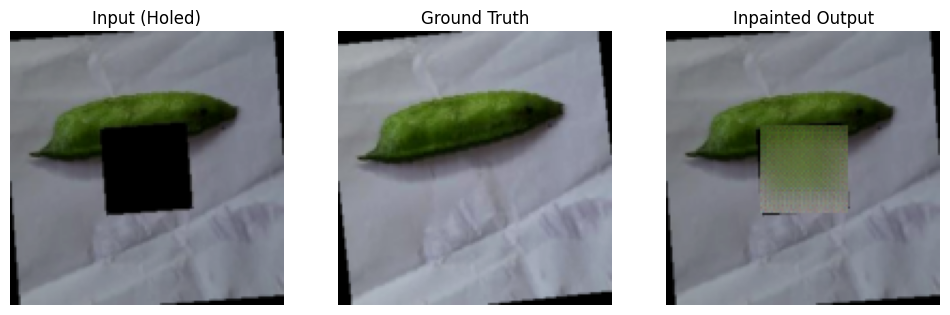

In [ ]:


# Visualize the results
visualize_inpainting(test_loader, model)


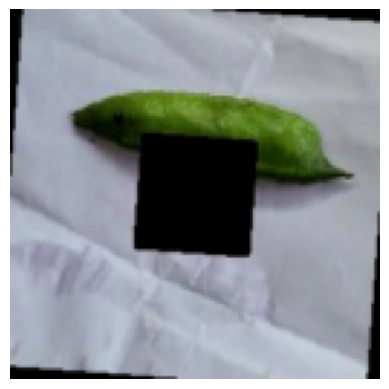

In [ ]:
import matplotlib.pyplot as plt

for combined_input, target in test_loader:
    input_image = combined_input[:, :3, :, :].cpu().permute(0, 2, 3, 1).numpy()
    input_image = (input_image * 255).astype(np.uint8)

    plt.imshow(input_image[0])  # Visualize the first image
    plt.axis("off")
    plt.show()
    break


In [17]:
def evaluate_model(test_loader, model, loss_fn, log_to_mlflow=True):
    """
    Evaluate the model on the test dataset.

    Args:
        test_loader (DataLoader): DataLoader for the test dataset.
        model (nn.Module): Trained inpainting model.
        loss_fn (callable): Loss function for evaluation.
        log_to_mlflow (bool): Whether to log the evaluation metrics to MLflow.

    Returns:
        dict: Evaluation results containing test loss and optional metrics.
    """
    model.eval()
    total_loss = 0.0
    total_psnr = 0.0  # For computing PSNR

    num_batches = len(test_loader)
    total_images = num_batches * test_loader.batch_size

    with torch.no_grad():
        for combined_input, target in test_loader:
            combined_input, target = combined_input.to(device), target.to(device)
            mask = combined_input[:, 3:4, :, :]  # Extract the mask channel
            output = model(combined_input)

            # Compute loss
            loss = masked_loss(output, target, mask)
            total_loss += loss.item()

            # Compute additional metrics (e.g., PSNR)
            output_np = (output.cpu().numpy() * 255).astype(np.uint8)
            target_np = (target.cpu().numpy() * 255).astype(np.uint8)
            for b in range(output_np.shape[0]):  # Loop over the batch
                psnr = compute_psnr(output_np[b], target_np[b])
                total_psnr += psnr

    avg_loss = total_loss / num_batches
    avg_psnr = total_psnr / total_images

    # Log results to MLflow
    if log_to_mlflow:
        mlflow.log_metric("Test Loss", avg_loss)
        mlflow.log_metric("Test PSNR", avg_psnr)
        mlflow.log_param("Total Test Images", total_images)  # Log number of images

    # Print results
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test PSNR: {avg_psnr:.4f}")
    print(f"Total Test Images: {total_images}")

    return {
        "test_loss": avg_loss,
        "test_psnr": avg_psnr,
        "total_test_images": total_images,
    }


# Helper function to compute PSNR
def compute_psnr(output, target):
    mse = np.mean((output - target) ** 2)
    if mse == 0:
        return float('inf')  # PSNR is infinite if there's no error
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr





In [ ]:
with open("mlflow_run_id.txt", "r") as f:
    run_id = f.read().strip()

# Continue the run or start logging to the same run
with mlflow.start_run(run_id=run_id):

# Evaluate the model
    evaluation_results = evaluate_model(test_loader, model, loss_fn)
mlflow.end_run()

Test Loss: 0.1262
Test PSNR: 24.4542
Total Test Images: 320
